# Neural Network with LeakyReLU activation function

Net is implemented in **neural_net_improved.py**. Here is only training.
Result: achieved accuracy 55.1% on the train set, 56.7 - validation set.

In [1]:
# A bit of setup

import numpy as np
import matplotlib.pyplot as plt

from cs231n.classifiers.neural_net_improved import TwoLayerNetImproved

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# Test our implementation

In [2]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNetImproved(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

In [3]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

b2 max relative error: 2.856083e-11
W1 max relative error: 2.031343e-07
W2 max relative error: 2.526915e-09
b1 max relative error: 2.456633e-07


# Load the data
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

In [5]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


# Train a network
To train our network we will use SGD with momentum. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [6]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNetImproved(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)



iteration 0 / 1000: loss 2.302954
iteration 100 / 1000: loss 2.302539
iteration 200 / 1000: loss 2.297411
iteration 300 / 1000: loss 2.257663
iteration 400 / 1000: loss 2.201097
iteration 500 / 1000: loss 2.115917
iteration 600 / 1000: loss 2.050565
iteration 700 / 1000: loss 1.986271
iteration 800 / 1000: loss 2.005007
iteration 900 / 1000: loss 1.950218
Validation accuracy:  0.286


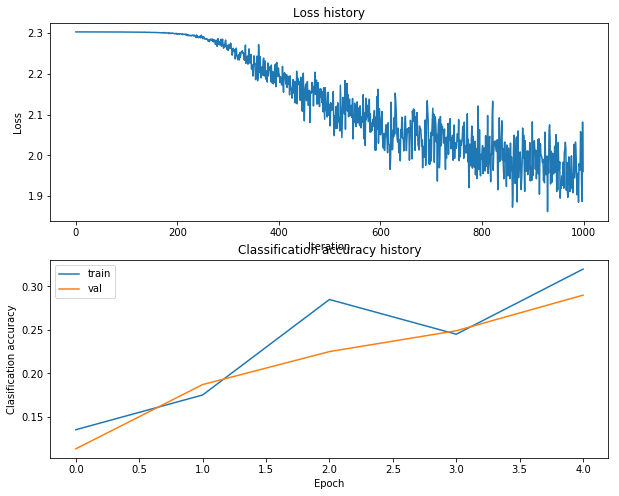

In [7]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

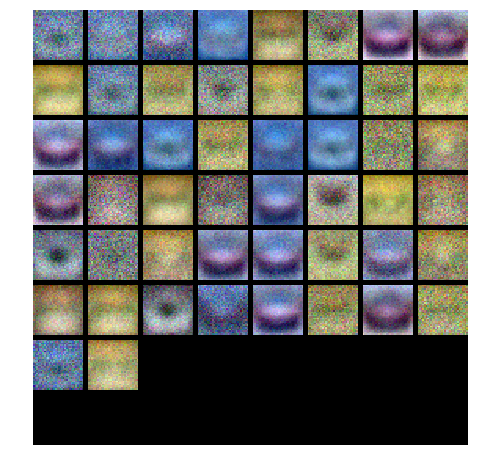

In [8]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

# Tune your hyperparameters

In [9]:
import copy

In [10]:
best_net = None # store the best model into this 

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################
input_size = 32 * 32 * 3
num_classes = 10

results = {}
best_val = -1
hidden_sizes = [50, 100, 300, 500, 700, 1000, 1500, 2000]

num_try = 100
iterations_per_epoch = max(X_train.shape[0] // 200, 1)
for _ in range(num_try):
    hidden_size = np.random.choice(hidden_sizes, 1)[0]
    lr = 10 ** np.random.uniform(-5, -3)
    reg = 10 ** np.random.uniform(-4, 0)
    
    current_model = TwoLayerNetImproved(input_size, hidden_size, num_classes)
    history = current_model.train(X_train, y_train, X_val, y_val,
                                        num_iters=iterations_per_epoch * 5, batch_size=200,
                                        learning_rate=lr, learning_rate_decay=0.95,
                                        reg=reg, verbose=False)
    current_val_acc = history["val_acc_history"][-1]
    current_train_acc = history["train_acc_history"][-1]
    results[(hidden_size, lr, reg)] = current_val_acc
    if current_val_acc > best_val:
        best_val = current_val_acc
        best_net = current_model
    print('lr: %e reg: %e hidden: %d | train accuracy: %f val accuracy: %f' % (
            lr, reg, hidden_size, current_train_acc, current_val_acc))
print()        
    
print('best validation accuracy achieved during parameter search: %f' % best_val)

#################################################################################
#                               END OF YOUR CODE                                #
#################################################################################

lr: 1.495747e-05 reg: 1.461567e-03 hidden: 1000 | train accuracy: 0.230000 val accuracy: 0.237000
lr: 2.229448e-05 reg: 6.449021e-01 hidden: 700 | train accuracy: 0.175000 val accuracy: 0.203000
lr: 9.963260e-05 reg: 8.883537e-01 hidden: 50 | train accuracy: 0.290000 val accuracy: 0.279000
lr: 1.852821e-05 reg: 5.063911e-02 hidden: 50 | train accuracy: 0.185000 val accuracy: 0.211000
lr: 1.299289e-04 reg: 1.253549e-04 hidden: 700 | train accuracy: 0.380000 val accuracy: 0.346000
lr: 3.562075e-05 reg: 1.047393e-04 hidden: 500 | train accuracy: 0.180000 val accuracy: 0.215000
lr: 5.803995e-05 reg: 1.103868e-02 hidden: 500 | train accuracy: 0.335000 val accuracy: 0.264000
lr: 1.424727e-04 reg: 3.477854e-03 hidden: 2000 | train accuracy: 0.435000 val accuracy: 0.374000
lr: 4.137085e-05 reg: 3.815695e-04 hidden: 50 | train accuracy: 0.195000 val accuracy: 0.201000
lr: 1.323326e-05 reg: 3.395185e-02 hidden: 1500 | train accuracy: 0.200000 val accuracy: 0.233000
lr: 2.932271e-05 reg: 3.568355

lr: 1.278274e-04 reg: 8.802996e-01 hidden: 300 | train accuracy: 0.350000 val accuracy: 0.335000
lr: 4.423386e-04 reg: 4.586621e-04 hidden: 500 | train accuracy: 0.465000 val accuracy: 0.465000
lr: 3.067723e-04 reg: 1.258960e-03 hidden: 2000 | train accuracy: 0.470000 val accuracy: 0.439000
lr: 2.319475e-04 reg: 3.164394e-04 hidden: 500 | train accuracy: 0.410000 val accuracy: 0.405000
lr: 1.626274e-05 reg: 5.433391e-03 hidden: 700 | train accuracy: 0.175000 val accuracy: 0.214000
lr: 9.903945e-04 reg: 4.914133e-02 hidden: 1000 | train accuracy: 0.565000 val accuracy: 0.493000
lr: 7.290990e-04 reg: 1.636025e-01 hidden: 2000 | train accuracy: 0.525000 val accuracy: 0.486000
lr: 3.597509e-04 reg: 1.347192e-02 hidden: 100 | train accuracy: 0.495000 val accuracy: 0.435000
lr: 2.122115e-04 reg: 5.261907e-03 hidden: 700 | train accuracy: 0.365000 val accuracy: 0.396000
lr: 2.244794e-04 reg: 6.206812e-03 hidden: 700 | train accuracy: 0.365000 val accuracy: 0.418000
lr: 3.764430e-04 reg: 3.248

In [11]:
# let's train out best model for some more epochs, so make a copy

In [12]:
import copy

In [13]:
experimental_model = copy.deepcopy(best_net)

In [14]:
hidden_size, lr, reg = sorted(results.keys(), key=lambda x: results[x])[-1]

In [15]:
history = experimental_model.train(X_train, y_train, X_val, y_val,
                                        num_iters=iterations_per_epoch * 30, batch_size=200,
                                        learning_rate=lr * (0.95 ** 5), learning_rate_decay=0.95,
                                        reg=reg, verbose=True)

iteration 0 / 7350: loss 1.315032
iteration 100 / 7350: loss 1.275263
iteration 200 / 7350: loss 1.244949
iteration 300 / 7350: loss 1.298397
iteration 400 / 7350: loss 1.304656
iteration 500 / 7350: loss 1.404807
iteration 600 / 7350: loss 1.117302
iteration 700 / 7350: loss 1.217139
iteration 800 / 7350: loss 1.246209
iteration 900 / 7350: loss 1.188669
iteration 1000 / 7350: loss 1.237210
iteration 1100 / 7350: loss 1.097224
iteration 1200 / 7350: loss 1.151324
iteration 1300 / 7350: loss 1.028241
iteration 1400 / 7350: loss 1.080870
iteration 1500 / 7350: loss 1.273055
iteration 1600 / 7350: loss 1.043975
iteration 1700 / 7350: loss 1.096476
iteration 1800 / 7350: loss 1.094055
iteration 1900 / 7350: loss 0.933623
iteration 2000 / 7350: loss 0.978305
iteration 2100 / 7350: loss 1.042704
iteration 2200 / 7350: loss 1.069018
iteration 2300 / 7350: loss 1.076390
iteration 2400 / 7350: loss 0.999136
iteration 2500 / 7350: loss 0.969018
iteration 2600 / 7350: loss 0.868499
iteration 270

In [16]:
print('validation accuracy achieved during additional training: %f' % history["val_acc_history"][-1])

validation accuracy achieved during additional training: 0.567000


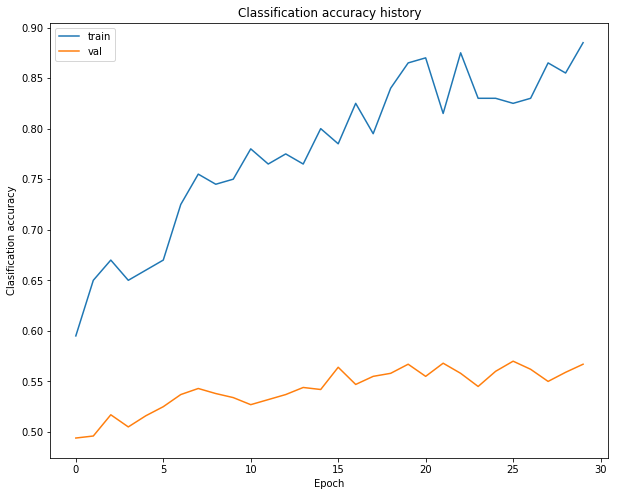

In [17]:
plt.plot(history['train_acc_history'], label='train')
plt.plot(history['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

In [18]:
# so as we can see, we have achieved rather good accuracy above 55% on the validation set, so save the model
best_net = experimental_model
best_val = history["val_acc_history"][-1]

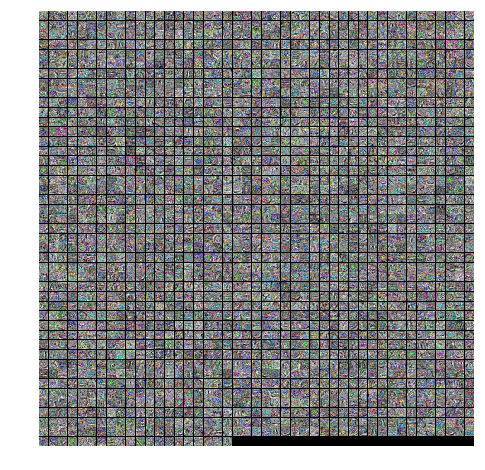

In [19]:
# visualize the weights of the best network
show_net_weights(best_net)

# Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.

**We will give you extra bonus point for every 1% of accuracy above 52%.**

In [20]:
test_acc = (experimental_model.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.551
